<center>

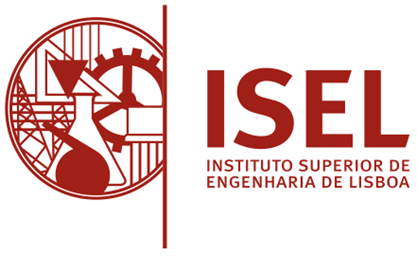
<h2>
Instituto Superior de Engenharia de Lisboa

Licenciatura Engenharia Informática e Multimédia

Ano letivo 2024/2025

Aprendizagem Automática

Trabalho concretizado pelos alunos:

Benjamim Noronha nº50731

Gonçalo Clementino nº50736

Fransisco Sousa nº 50795


Docente: Gonçalo Silva

<h2>

29 de dezembro de 2024
</center>



## Introdução mudar

<h4>
No ambito da unidade curricular Aprendizagem automática, realizou o 2º trabalho prático, em que predente-se cumprir os objetivos propostos.

Estes objetivos são: Dado um ficheiro com as criticas de cinema e as notas atribuidas pelos utilizadores (de 1 a 4 e 7 a 10) do site IMDb, precisamos de: treinar um classificador multi-classe, de maneira a prever a nota da critica em base do texto da critica; treinar e avaliar um regressor que este prevê a pontuação da critica; e fazer clustering das críticas.

Neste trabalho será utilizado os classificadores RandomForestClassifier (como pedido no enunciado), Logistic Regression e Support Vetor Machine, para conseguir escolher os melhores híper parametros usou-se o modelo GridSearch e para o pré-processamento de dados usou-se o StandarScaler.
</h4>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import sklearn.preprocessing as pp
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from plotMatriz import plotMatriz

#### Carrega-se os dados do IMDb

In [2]:
file = open("imdbFull.p", "rb")
dados = pickle.load(file)

In [3]:
print(dados.keys())

dict_keys(['data', 'target', 'DESCR'])


#### Os dados ficam divididos em criticas de texto e as respetivas pontuações

In [4]:
Docs = dados['data']
y = dados['target']
des = dados['DESCR']
des

'This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.\nFor more details see: http://ai.stanford.edu/~amaas/data/sentiment/'

#### Observa-se que o tipo de dado da critica já esta em string

In [5]:
print(type(Docs[1]))
print(Docs[0])

<class 'str'>
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


#### 15 a 20 segundos o tfidf
## Construção do vocabulário

<h4> 
Nesta etapa constroi-se o vocabulário, importante para melhorar o desempenho dos modelos, seja de classificação ou regressão, onde será necessario também de existir uma limpeza nos textos das criticas, de maneira a diminuir o ruído de palavras e dar relevancia maior a certas palavras, assim como deixar o algoritmo dos modelos mais rapidos pela diminuição das palavras.


Acontece uma limpeza nas criticas, onde elimina-se as tags br de break, e torna a string em unicode.
Seguidamente, aplica-se um filtro, limpando mais o vocabulario, em que só conta palavras de 4 letras ou mais que apareçam em pelo menos 5 criticas.

É usado o TfidVectorizer para mostrar o valor relativo da palavra nos documentos, onde se a palavra aparece mais vezes num dado documento, ganha mais valor, mas se aparecer em vários documentos, perde o seu valor. Não se usa CountVectorizer (que conta as palavras) e TfidfTransformer (que faz o valor relativo da palavra) uma vez que o TfidVectorizer já faz ambos. 

In [6]:
# Docs1 = [doc.decode('UTF-8') for doc in Docs_ps] #ja estão em str, n é byte
Docs_normal = [doc.replace('<br />', ' ') for doc in Docs]
Docs_normal = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc)
               for doc in Docs_normal]

print(Docs_normal[1])

tfidf = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_normal)
X_ws = tfidf.transform(Docs_normal)

Words can t describe how bad this movie is I can t explain it by writing only You have too see it for yourself to get at grip of how horrible a movie really can be Not that I recommend you to do that There are so many clichés mistakes and all other negative things you can imagine here that will just make you cry To start with the technical first there are a LOT of mistakes regarding the airplane I won t list them here but just mention the coloring of the plane They didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original Boeing livery Very bad The plot is stupid and has been done many times before only much much better There are so many ridiculous moments here that i lost count of it really early Also I was on the bad guys side all the time in the movie because the good guys were so stupid Executive Decision should without a doubt be you re choice over this one even the Turbulence movies are better In fact every other movie 

#### Acontece a separação do texto de criticas, em dados de treino e teste, além disso, faz-se um pre-processamento de dados (sem retirar a média, porque está a aplicar numamatriz esparsa) para verificar se melhora os resultados ao pré processar os dados

In [7]:
X_ws1, X_ws2, ytreino, yteste = train_test_split(
    X_ws, y, test_size=0.2, random_state=0
)
sc = pp.StandardScaler(with_mean=False)
sc1 = sc.fit(X_ws1)

XtreinoN = sc1.transform(X_ws1)
XtesteN = sc1.transform(X_ws2)

<h4>
Usou-se a regressão logistica como classificador, o objetivo nesta etapa não é classificar propriamente mas sim, usando um classificador simples, observar por alto a pontuação do classificador para os dados de treino e teste, e comparar esta pontuação com a pontuação dada usando o pré-processamento de dados

Verifica-se que utilizar o pré-processamento de dados piorou bastante o classificador, onde é evidente o overfit, isso é, maior pontuação nos dados de treino mas com uma grande diferença na pontuação de treino com teste, onde a pontuação dos dados de teste são piores. Isso se deve por não retirar a média para a normalização.

In [8]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ws1, ytreino)
print(dl.score(X_ws1, ytreino), "de score de treino")
print(dl.score(X_ws2, yteste), "de score de teste")

0.672475 de score de treino
0.4417 de score de teste


In [9]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(XtreinoN, ytreino)
print(dl.score(XtreinoN, ytreino), "de score de treino")
print(dl.score(XtesteN, yteste), "de score de teste")

0.999875 de score de treino
0.3635 de score de teste


#### Nesta etapa, cria-se stemmers, que serve para reduzir a palavra para a sua palavra raiz (que pode nem existir no dicionario), em que serve para mapear várias palavras semelhantes, reduzindo a quantidade de palavras. 

#### Usará 3 stemmers, Porter, Snowball e Lacaster, onde o Lacaster reduz mais e o Porter menos

#### Será utilizado classificadores simples para observar, por alto, os resultados dados a estes stemmers e compara-los, para depois utilizar um destes vocabularios para a classificação

In [10]:
stemFunc = PorterStemmer()

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ps] #ja estão em str, n é byte
Docs_ps = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ps[1])

tfidf_ps = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ps)
X_ps = tfidf_ps.transform(Docs_ps)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [11]:
X_ps1, X_ps2, ytreino_ps, yteste_ps = train_test_split(
    X_ps, y, test_size=0.2, random_state=0
)

In [12]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ps1, ytreino_ps)
print(dl.score(X_ps1, ytreino_ps), "de score de treino")
print(dl.score(X_ps2, yteste_ps), "de score de teste")

0.675425 de score de treino
0.4401 de score de teste


In [13]:
stemFunc = SnowballStemmer(language='english')

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ss] #ja estão em str, n é byte
Docs_ss = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ss[1])

tfidf_ss = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ss)
X_ss = tfidf_ss.transform(Docs_ss)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [14]:
X_ss1, X_ss2, ytreino_ss, yteste_ss = train_test_split(
    X_ss, y, test_size=0.2, random_state=0
)

In [15]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ss1, ytreino_ss)
print(dl.score(X_ss1, ytreino_ss), "de score de treino")
print(dl.score(X_ss2, yteste_ss), "de score de teste")

0.674325 de score de treino
0.4414 de score de teste


In [16]:
stemFunc = LancasterStemmer()

# Docs_ls1 = [doc.decode('UTF-8') for doc in Docs_ls] #ja estão em str, n é byte
Docs_ls = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ls[1])

tfidf_ls = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ls)
X_ls = tfidf_ls.transform(Docs_ls)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [17]:
X_ls1, X_ls2, ytreino_ls, yteste_ls = train_test_split(
    X_ls, y, test_size=0.2, random_state=0
)

In [18]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ls1, ytreino_ls)
print(dl.score(X_ls1, ytreino_ls), "de score de treino")
print(dl.score(X_ls2, yteste_ls), "de score de teste")

0.67215 de score de treino
0.4416 de score de teste


#### Repara-se que a diferença entre os stremmers é pequena, onde o Lacaster foi o que teve melhor pontuação e o Porter a pior, ainda assim, estes têm, por pouco, piores resultados que sem o vocabulario sem stemmers.

#### Mesmo assim, será utilizado o stemmer para o objetivo da classificação e regressão, uma vez que é eficaz em termos de tempo, onde pelo seu tamanho reduzido, os modelos processarão mais rapidamente, mesmo que perda alguma informação para classificar melhor

#### No caso, será usado o Snowball ao ínves do Lacaster,m dos stemmers, que será abordado nas próximas etapas.

## Classificação

### 20 min o gridsearch

#### Será utilizado o Logistic Regression como classificador, pro seu otimo desempenho, e será encontrado os melhores híper-parametros deste classificador para um melhor comportamento, onde para encontrar os melhores híper-parametros será utilizado o grid search, e verificará-se os hiper-parametros C (força inversa a regularização), o tipo de penalidade (l1 de lasso e l2 de ridge), e o tipo de otimização (solver, onde pode ser saga, para suportar o l1, e lbfgs, que não suporta o l1)


In [19]:
""" param_grid_logreg = {
    'C': np.arange(0.1, 1.3, 0.1),
    'penalty': np.array(['l1', 'l2']),
    'solver': np.array(['saga', 'lbfgs'])

}
grid_search_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)
grid_search_logreg.fit(X_ss1, ytreino_ss)
logreg_params = grid_search_logreg.best_params_
print("Best Parameters:", logreg_params)
print("Best Score:", grid_search_logreg.best_score_) """

' param_grid_logreg = {\n    \'C\': np.arange(0.1, 1.3, 0.1),\n    \'penalty\': np.array([\'l1\', \'l2\']),\n    \'solver\': np.array([\'saga\', \'lbfgs\'])\n\n}\ngrid_search_logreg = GridSearchCV(\n    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)\ngrid_search_logreg.fit(X_ss1, ytreino_ss)\nlogreg_params = grid_search_logreg.best_params_\nprint("Best Parameters:", logreg_params)\nprint("Best Score:", grid_search_logreg.best_score_) '

#### Esta célula existe já para por os melhores híper-parametros, uma vez que já foi determinado no gridsearch, serve para comentar a célula do gridsearch para não demorar muito tempo quando é dado run ao código todo (a célula do gridsearch demora 20 min)

In [20]:
logreg_params = {'C': np.float64(
    0.9), 'penalty': np.str_('l2'), 'solver': 'saga'}

In [21]:
classes = np.array([1, 2, 3, 4, 7, 8, 9, 10])

<h4>
Utilizou-se os melhores híper-parametros no classificador LogisticRegression, é treinado com o conjunto de treino, e com isso faz um predição cruzada dos dados de teste, de maneira a obter-se a quantidade de erros na classificação e a matriz de confusão. Igualmente faz-se a validação cruzada do conjunto de teste, onde obtem-se o desempenho geral do classificador com seus híper-parametros, onde é marca 43,73% de score nos dados de treino, e 41,16% de score nos dados de teste. 


A vantagem da predição e validação cruzada é a consistencia dos dados, onde o classificador não apanha um padrão de dados faceis ou dificeis, ainda assim utilizou-se o score normal, o que não tem validação, para puder comparar com o classificador simples, feito anteriormente, quando era para escolher o stremmer.

Em comparação com o classificdor simplificado, o score dos dados de treino diminuiu, cerca de 1%, mas os de teste aumentaram, cerca de 0,03%, ou seja, diminuiu ligeiramente o overfit.



5884 erros
0.662175
43.73 de score de treino
0.4417
41.16 de score de teste


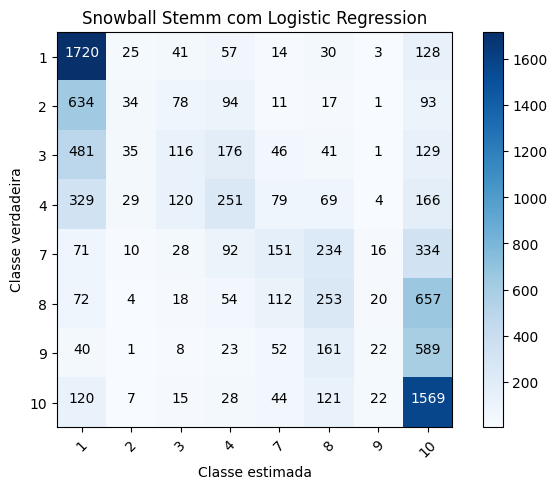

In [22]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1, ytreino_ss)

predict_dl = cross_val_predict(dl, X_ss2, yteste_ss)
print(np.sum(predict_dl != yteste_ss), "erros")
cm = confusion_matrix(yteste_ss, predict_dl)


plotMatriz(cm, classes=classes, title="Snowball Stemm com Logistic Regression")

print(dl.score(X_ss1, ytreino_ss))
print(np.round(np.mean(cross_val_score(dl, X_ss1, ytreino_ss))*100, 2),
      "de score de treino")
print(dl.score(X_ss2, yteste_ss))
print(np.round(np.mean(cross_val_score(dl, X_ss2, yteste_ss))*100, 2),
      "de score de teste")

#### Neste ponto, foi feito com o vocabulario utilizando o Lacaster Stremmer, onde o resultado foi pior, apresentando um pior score na validação cruzada.

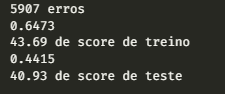

#### Ainda fez-se o vocabulario usando o Snowball Stremmer, só que com bi-gramas, ou seja, não apenas uma palavra vai desempenhar um valor relativo no documento, mas também duas palavras podem desempenhar. 

#### A utilidade deste tipo de vocabulario ser útil para situações em que no texto acontece uma sequencia de palavras que muda o significado, como "not good" que tem um significado negativo, em contrapartida, aumenta o ruído no valor relativo das palavras, onde será um ponto que queremos verificar

In [23]:
tfidf_ss_bi = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b', ngram_range=(1, 2)).fit(Docs_ss)
X_ss_bi = tfidf_ss_bi.transform(Docs_ss)

In [24]:
X_ss1_bi, X_ss2_bi, ytreino_ss_bi, yteste_ss_bi = train_test_split(
    X_ss_bi, y, test_size=0.2, random_state=0
)

#### Verifica-se que o resultado é pior no desempenho do classificador e acontece um aumento de overfit, isso tudo se deve pelo aumento do ruído.

6007 erros
44.27 de score de treino
39.93 de score de teste


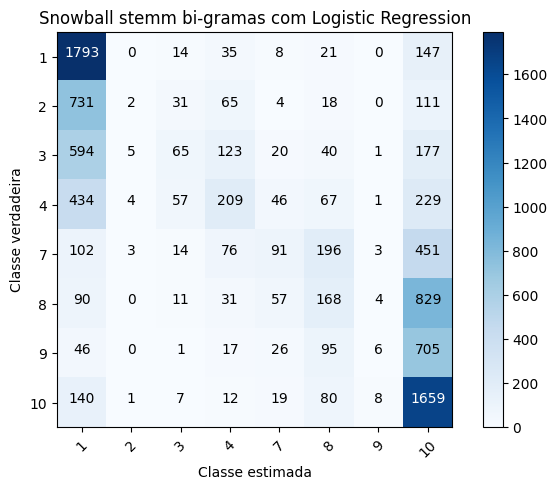

In [25]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1_bi, ytreino_ss_bi)

predict_dl = cross_val_predict(dl, X_ss2_bi, yteste_ss_bi)
print(np.sum(predict_dl != yteste_ss_bi), "erros")
cm = confusion_matrix(yteste_ss_bi, predict_dl)
plotMatriz(cm, classes=classes,
           title="Snowball stemm bi-gramas com Logistic Regression")


print(np.round(np.mean(cross_val_score(dl, X_ss1_bi, ytreino_ss_bi))
      * 100, 2), "de score de treino")
print(np.round(np.mean(cross_val_score(dl, X_ss2_bi, yteste_ss_bi))
      * 100, 2), "de score de teste")

#### Ainda usou-se uma maquina suporte a vectores, simples no momento que foi feito, mas o tempo gasto, cerca de 67 minutos, e o resultado dado, cerca de 20% do desempenho, foram o suficientes para desconsiderar utilizar tal classificador, onde comentou-se a célula para não executar, mas existe uma imagem que mostra o resultado.

In [26]:
""" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)
print(dl.score(X_ss1, ytreino))
print(dl.score(X_ss2, yteste)) """

" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)\nprint(dl.score(X_ss1, ytreino))\nprint(dl.score(X_ss2, yteste)) "

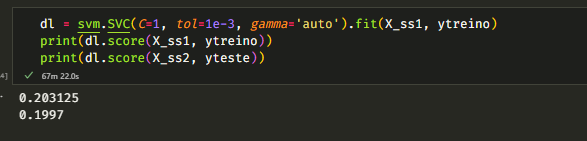

### 1 min

## Regressores

#### Nesta etapa, usasse regressores para prever a pontuação da critica, sendo um número continuo.


In [27]:
param_grid_lasso = {
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}


grid_search_lasso = GridSearchCV(
    Lasso(random_state=0),  param_grid_lasso, n_jobs=-1
)
grid_search_lasso.fit(X_ss1, ytreino_ss)

lasso_params = grid_search_lasso.best_params_
print("Melhor valor de alpha:", lasso_params)
print("Melhor score de validação cruzada (R²):", grid_search_lasso.best_score_)

Melhor valor de alpha: {'alpha': np.float64(0.001)}
Melhor score de validação cruzada (R²): 0.5138510329547669


In [28]:
las = Lasso(**lasso_params, random_state=0).fit(X_ss1, ytreino_ss)

y_las_1 = las.predict(X_ss1)
y_las_2 = las.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_las_1))
print("R² no teste:", r2_score(yteste_ss, y_las_2))


print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_las_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_las_2))

R² no treino: 0.5208076257853331
R² no teste: 0.515397867025337
Erro médio absoluto (MAE) no teste: 2.0290134643565185
Erro médio quadrático (MSE) no teste: 5.859619023047476


[7.66065521 5.11056052 5.46761138 ... 6.54724381 8.03655931 5.86311438]
[8. 4. 4. ... 7. 8. 7.]
[ 8  7  4 ...  7 10  7]
0.2155
7845 erros


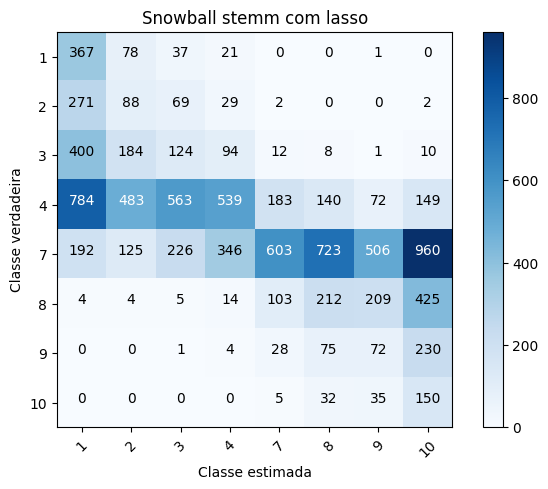

In [29]:
print(y_las_2)
y_pred_las_class_test = np.round(y_las_2)
y_pred_las_class_test[y_pred_las_class_test > 10.] = 10.
y_pred_las_class_test[y_pred_las_class_test < 1.] = 1.
y_pred_las_class_test[y_pred_las_class_test == 5.] = 4.
y_pred_las_class_test[y_pred_las_class_test == 6.] = 7.

print(y_pred_las_class_test)
print(ytreino_ss)
print(np.sum(y_pred_las_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_las_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_las_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com lasso")

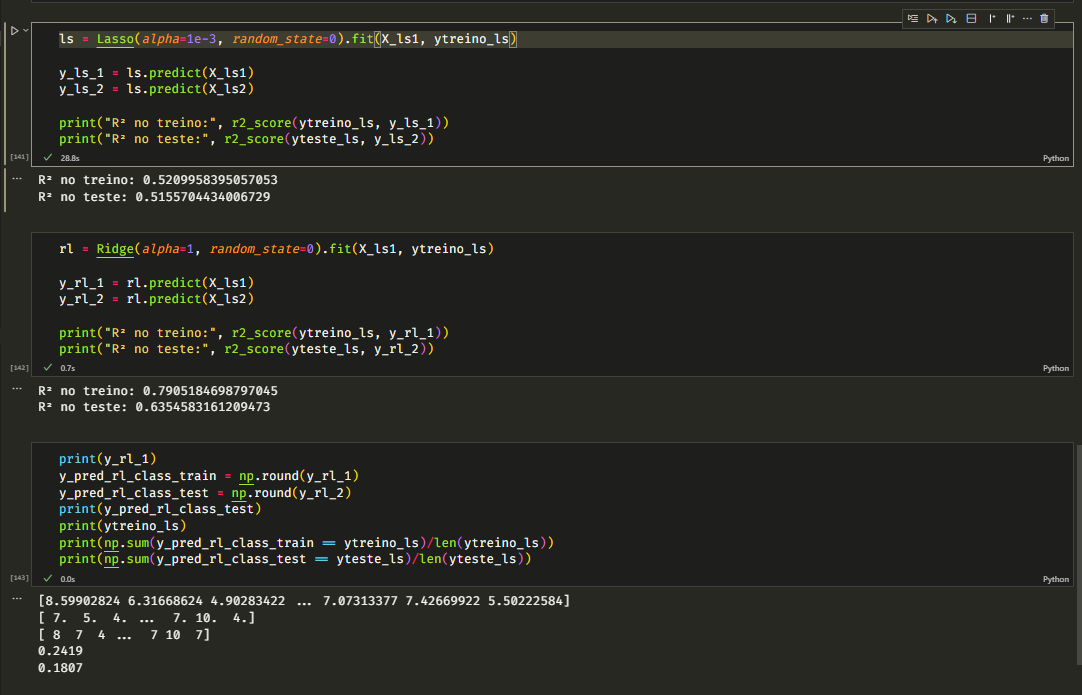

### quase 1 min

In [30]:
param_grid_ridge = {
    # Altere os valores de alpha conforme necessário
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}

# Configurando o GridSearchCV
grid_search_ridge = GridSearchCV(
    Ridge(random_state=0),  param_grid_ridge, n_jobs=-1
)

# Ajustando o modelo
grid_search_ridge.fit(X_ss1, ytreino_ss)

# Obtendo os melhores parâmetros e score
ridge_params = grid_search_ridge.best_params_
print("Melhor valor de alpha:", ridge_params)
print("Melhor score de validação cruzada (R²):", grid_search_ridge.best_score_)

Melhor valor de alpha: {'alpha': np.float64(1.0)}
Melhor score de validação cruzada (R²): 0.6345658582084799


In [31]:
rl = Ridge(**ridge_params, random_state=0).fit(X_ss1, ytreino_ss)

y_rl_1 = rl.predict(X_ss1)
y_rl_2 = rl.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_rl_1))
print("R² no teste:", r2_score(yteste_ss, y_rl_2))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_rl_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_rl_2))

R² no treino: 0.7904298284094093
R² no teste: 0.6354906295696898
Erro médio absoluto (MAE) no teste: 1.6788094416009998
Erro médio quadrático (MSE) no teste: 4.407504415925008


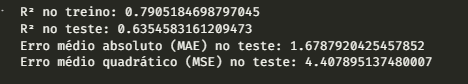

[ 6.5864819   4.9785682   4.13490727 ...  7.2916463  10.20903429
  4.0752353 ]
[ 7.  4.  4. ...  7. 10.  4.]
[ 8  7  4 ...  7 10  7]
0.2678
7322 erros


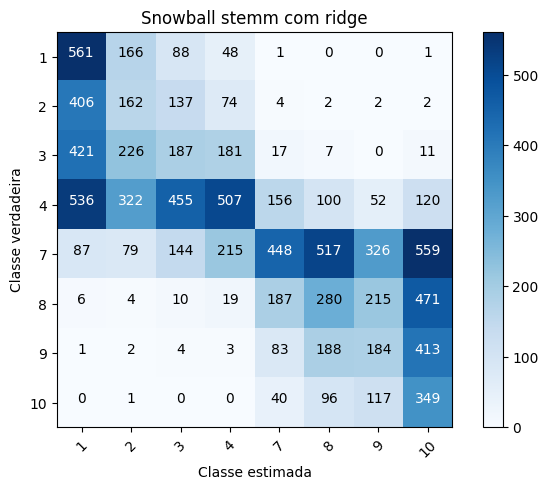

In [32]:
print(y_rl_2)
y_pred_rl_class_test = np.round(y_rl_2)
y_pred_rl_class_test[y_pred_rl_class_test > 10.] = 10.
y_pred_rl_class_test[y_pred_rl_class_test < 1.] = 1.
y_pred_rl_class_test[y_pred_rl_class_test == 5.] = 4.
y_pred_rl_class_test[y_pred_rl_class_test == 6.] = 7.

print(y_pred_rl_class_test)
print(ytreino_ss)
print(np.sum(y_pred_rl_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_rl_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_rl_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com ridge")

In [33]:
model = LinearRegression(n_jobs=-1).fit(X_ss1, ytreino_ss)

y_pred_lr_train = model.predict(X_ss1)
y_pred_lr_test = model.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_pred_lr_train))
print("R² no teste:", r2_score(yteste_ss, y_pred_lr_test))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_pred_lr_test))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_pred_lr_test))

R² no treino: 0.9741590527445843
R² no teste: -5.979732080274361
Erro médio absoluto (MAE) no teste: 6.629555936170752
Erro médio quadrático (MSE) no teste: 84.39618418990477


[ 6.63355503e+00  1.04139943e+01  1.38230185e+00 ... -1.14762540e+00
  6.65549870e+00 -2.58031972e-03]
[ 7. 10.  1. ...  1.  7.  1.]
[ 7. 10.  1. ...  1.  7.  1.]
[ 8  7  4 ...  7 10  7]
0.2268
7732 erros


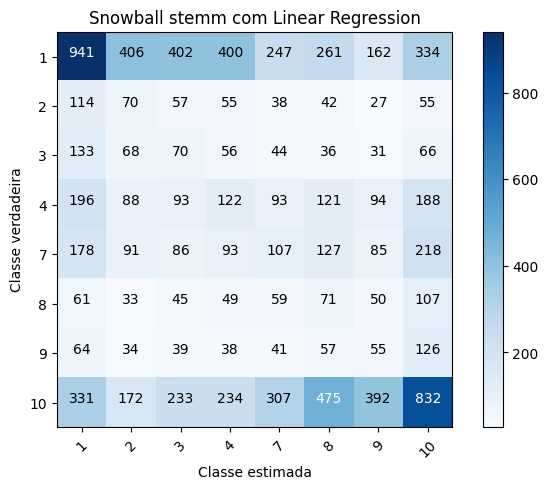

In [34]:
print(y_pred_lr_test)
y_pred_lr_class_test = np.round(y_pred_lr_test)
y_pred_lr_class_test[y_pred_lr_class_test > 10.] = 10.
y_pred_lr_class_test[y_pred_lr_class_test < 1.] = 1.
y_pred_lr_class_test[y_pred_lr_class_test == 5.] = 4.
y_pred_lr_class_test[y_pred_lr_class_test == 6.] = 7.
print(y_pred_lr_class_test)

print(y_pred_lr_class_test)
print(ytreino_ss)
print(np.sum(y_pred_lr_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_lr_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_lr_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com Linear Regression")

## Cluster

In [35]:
""" # Definindo diferentes números de clusters para análise
cluster_range = range(2, 6)
silhouette_scores = []

for n_clusters in cluster_range:
    # Modelo K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=9)
    kmeans.fit(X_ws)

    # Avaliação com índice de silhueta
    score = silhouette_score(X_ws, kmeans.labels_)
    silhouette_scores.append(score)

    print(f"Número de clusters: {n_clusters}, Silhouette Score: {score:.4f}")

# Plotando o índice de silhueta para diferentes valores de clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Índice de Silhueta para Diferentes Números de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show() """

' # Definindo diferentes números de clusters para análise\ncluster_range = range(2, 6)\nsilhouette_scores = []\n\nfor n_clusters in cluster_range:\n    # Modelo K-Means\n    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=9)\n    kmeans.fit(X_ws)\n\n    # Avaliação com índice de silhueta\n    score = silhouette_score(X_ws, kmeans.labels_)\n    silhouette_scores.append(score)\n\n    print(f"Número de clusters: {n_clusters}, Silhouette Score: {score:.4f}")\n\n# Plotando o índice de silhueta para diferentes valores de clusters\nplt.figure(figsize=(8, 5))\nplt.plot(cluster_range, silhouette_scores, marker=\'o\')\nplt.title("Índice de Silhueta para Diferentes Números de Clusters")\nplt.xlabel("Número de Clusters")\nplt.ylabel("Silhouette Score")\nplt.grid()\nplt.show() '

In [36]:
# Selecionando o número de clusters ideal (exemplo: 4 clusters)
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:  # Exibindo 3 exemplos por cluster
        print(f"- {doc}...")  # Mostrando os primeiros 150 caracteres


Cluster 0: 27690 documentos
Exemplo de críticas:
- Zero Day leads you to think even re think why two boys young men would do what they did commit mutual suicide via slaughtering their classmates It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction It is not a perfect movie but given what money time the filmmaker and actors had it is a remarkable product In terms of explaining the motives and actions of the two young suicide murderers it is better than Elephant in terms of being a film that gets under our rationalistic skin it is a far far better film than almost anything you are likely to see Flawed but honest with a terrible honesty ...
- Everyone plays their part pretty well in this little nice movie Belushi gets the chance to live part of his life differently but ends up realizing that what he had was going to be just as good or maybe even better The

In [37]:
# Selecionando o número de clusters ideal (exemplo: 4 clusters)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:  # Exibindo 3 exemplos por cluster
        print(f"- {doc}...")  # Mostrando os primeiros 150 caracteres


Cluster 0: 3995 documentos
Exemplo de críticas:
-  Show People is an absolutely delightful silent directed by King Vidor and starring Marion Davies and Billy Haines What gems both of them are in this charming comedy about a young girl Peggy Pepper whose acting is the talk of Savannah trying to make it on the big screen Though she s a success in comedy what she wants to do is make art so she moves up to High Arts Studio Soon she becomes Patricia Pepoire and is too good for the likes of her friend Billy Many stars of the silent era have cameos in Show People including Davies herself without the curly hair and makeup I m sure when people saw the film in they recognized everyone who appeared in the elaborate lunch scene sadly nowadays it s not the case even for film buffs In one part of the film however she does meet Charlie Chaplin in another author Elinor Glyn is pointed out to her and Vidor himself has a cameo at the end of the film Other stars who pop up in Show People are John Gilber

In [38]:
# Selecionando o número de clusters ideal (exemplo: 4 clusters)
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:  # Exibindo 3 exemplos por cluster
        print(f"- {doc[:300]}...")  # Mostrando os primeiros 150 caracteres


Cluster 0: 3066 documentos
Exemplo de críticas:
-  Show People is an absolutely delightful silent directed by King Vidor and starring Marion Davies and Billy Haines What gems both of them are in this charming comedy about a young girl Peggy Pepper whose acting is the talk of Savannah trying to make it on the big screen Though she s a success in com...
- I love a good sappy love story and I m a guy but when I rented Love Story I prayed for the end to come as quickly and painlessly as possible and just the opposite for Ali McGraw s character Ali McGraw as Jenny alienated and irritated the heck out of me within the first minutes When we learn that she...
- Towards the end of this thriller Ally Sheedy s gaunt latter day image is used creatively to make up more than one hauntingly evil image She convinces one that if a nasty Bette Davis type role were to come her way she could carry it off brilliantly Unfortunately I can t find many other reasons for se...

Cluster 1: 9355 documentos
Exemp

## cluster 10 é sobre natal, 9 sobre artes marciais

In [40]:
# Selecionando o número de clusters ideal (exemplo: 4 clusters)
optimal_clusters = 20
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:  # Exibindo 3 exemplos por cluster
        print(f"- {doc[:300]}...")  # Mostrando os primeiros 150 caracteres
words = np.array(tfidf.get_feature_names_out())

# Exibir as 10 palavras mais relevantes por cluster
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {cluster_idx}:")
    # Indices das 10 maiores contribuições
    top_indices = centroid.argsort()[-20:][::-1]
    top_words = words[top_indices]  # Palavras correspondentes
    print(f"Top 10 palavras: {', '.join(top_words)}")


Cluster 0: 5472 documentos
Exemplo de críticas:
- Sorry but every time I see a film wherein a woman sucker punches a man and the man does nothing but cower the film looses all credibility So the new female Starbuck immediately tainted the plot before it even got off the ground no pun intended Dirk Benedict was so much more plausible as the sensitiv...
- Engaging riveting tale of captured US army turncoat who has to prove his innocence to avoid the hangman Paul Ryker dodges friendly fire in a seemingly doomed attempt to convince a military court that he was actually a US spy on a secret mission in Korea In the vein of classic courtroom dramas Sergea...
- When I noticed that Hamish Macbeth was being broadcast in the United States I was thrilled I then had the misfortune to watch the darn thing I adore M C Beaton s books about the wonderful Scottish Constable The characters in the book are entertaining and very well written The powers that be who are ...

Cluster 1: 1194 documentos
Exemp

R2 n é usado nos testes, so treino, é uma medida de ajuste do modelo

ver erro quadratico no teste

fazer os stemms, ver em cada um um classificador simples e dps escolher o que é melhor de score, a partir dai escohe-se o stemm e faz o grid search 

regressor da numeros continuos

arredontar o regressor para a classe mais proxima

questao do stor: se os regressores podem ter classificações como classificadores

k-means, cluster

mattriz de confusao e taxa de desempenho no teste

ver o efeito de ter 2... 10 clusters